# Training an LSTM NN

### Modelling strategy

I have decided to break the model architecture down into two parts: 
1. The first part should predict UPDRS at time horizon $t=0$ from the peptide features
2. The second will predict the time progression of the UPDRS, based on the output from the first model.

The advantage of breaking the model into two steps is that we can use much more patient UPDRS data for the second prediction step, since we have many data that are not linked to peptide measurements.

In [355]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

ImportError: cannot import name 'smape' from 'sklearn.metrics' (/Users/chrishedemann/neuefische/kgl-parkinsons/peptide-parkinsons-challenge/.venv/lib/python3.9/site-packages/sklearn/metrics/__init__.py)

In [264]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.models as models
from tensorflow.keras.layers import Dense, LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed

print(tf.__version__)

2.9.0


### Import data and pre-process

In [216]:
df_X = pd.read_csv('data/features_matrix.csv')
df_X

,visit_id,patient_id,visit_month,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,ADDLGKGGNEESTKTGNAGSR,ADSGEGDFLAEGGGVR,AEAQEAEDQQAR,...,VYAC(UniMod_4)EVTHQGLSSPVTK,WELALGR,WSGQTAIC(UniMod_4)DNGAGYC(UniMod_4)SNPGIPIGTR,YANC(UniMod_4)HLAR,YFIDFVAR,YGLVTYATYPK,YIETDPANR,YLYEIAR,YTTEIIK,YYC(UniMod_4)FQGNQFLR
0,55_0,55,0,53855.6,NaN,19735.4,114400.0,39389.3,NaN,9481.83,...,0,0,0,0,0,0,0,0,0,0
1,55_6,55,6,45251.9,49927.5,23820.4,90539.4,40871.1,44205.80,10315.90,...,0,0,0,0,0,0,0,0,0,0
2,55_12,55,12,53000.9,45519.2,17813.5,147312.0,35002.7,39179.60,7138.93,...,0,0,0,0,0,0,0,0,0,0
3,55_36,55,36,58108.4,52374.0,19373.3,64356.1,44147.9,39639.60,9959.98,...,0,0,0,0,0,0,0,0,0,0
4,942_6,942,6,42682.6,25698.8,17130.6,86471.5,22944.8,68677.50,5938.09,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,64674_48,64674,48,31434.3,11667.5,10309.1,12677.8,NaN,37408.50,NaN,...,0,0,0,0,0,0,0,0,0,0
564,65043_0,65043,0,95033.0,57483.7,11610.0,270739.0,46225.1,9668.03,5673.29,...,0,0,0,0,0,0,0,0,0,0
565,65043_12,65043,12,76532.7,54260.6,11631.9,230169.0,43775.4,50476.90,7533.18,...,0,0,0,0,0,0,0,0,0,0
566,65043_24,65043,24,75401.6,NaN,13313.9,220202.0,30188.3,16739.50,7079.75,...,0,0,0,0,0,0,0,0,0,0


In [217]:
df_y = pd.read_csv('data/target_matrix.csv')
df_y

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.0,6.0,15.0,0.0
1,55_6,55,6,8.0,10.0,34.0,0.0
2,55_12,55,12,10.0,10.0,41.0,0.0
3,55_18,55,18,7.0,13.0,38.0,0.0
4,55_24,55,24,16.0,9.0,49.0,0.0
...,...,...,...,...,...,...,...
1503,65043_36,65043,36,2.0,7.0,5.0,0.0
1504,65043_48,65043,48,7.0,6.0,13.0,0.0
1505,65043_54,65043,54,4.0,8.0,11.0,1.0
1506,65043_60,65043,60,6.0,6.0,16.0,1.0


Reshape target variable so that each feature sample has a prediction window of 4 timesteps, like
$t + (0,6,12,24)$

In [218]:
time_steps = np.array([0,6,12,24])
yy = []   # target (samples, month, updrs)

for patient in df_X.patient_id.unique():
    yy_patient = df_y.query("patient_id == @patient").set_index("visit_month")
    for visit in df_X[df_X.patient_id == patient].visit_month:
        new_sample = yy_patient.loc[list(time_steps+ visit)]
        new_line = new_sample[['updrs_1','updrs_2','updrs_3','updrs_4']].to_numpy()
        new_meta = np.array([patient,visit])
        
        yy.append(new_line)
        
yy = np.array(yy)

print("yy shape (samples, 4*target timestep, 4*target values): \n", yy.shape)
print("df_X shape (samples, 2*metadata + 582*features): \n",df_X.shape)

yy shape (samples, 4*target timestep, 4*target values): 
 (568, 4, 4)
df_X shape (samples, 2*metadata + 582*features): 
 (568, 585)


Test train split, before scaling. Then scale using Min-Max.

In [265]:
X_train, X_test, y_train, y_test = train_test_split(df_X, yy, test_size=0.2, random_state=12)

### Drop meta data from features matrix
meta_names = ['visit_id','patient_id','visit_month']

# Train
meta_train = X_train[meta_names].copy() 
X_train = X_train.drop(meta_names, axis=1)

# Test
meta_test = X_test[meta_names].copy() 
X_test = X_test.drop(meta_names, axis=1)

### Scale numeric features

# Get names of features
num_feat_names = pd.read_csv('data/numeric_peptide_features.csv',header=None).values.flatten()
bin_feat_names = pd.read_csv('data/binary_peptide_features.csv',header=None).values.flatten()

# Seperate numeric features
X_train_num = X_train[num_feat_names].fillna(0)
X_test_num = X_test[num_feat_names].fillna(0)

# Scale numeric
scaler = MinMaxScaler()

X_train_num_np = scaler.fit_transform(X_train_num) # fit to train data
X_test_num_np  = scaler.transform(X_test_num) # only tranform test data, no data leakage

# Put features back together again
X_train[num_feat_names] = X_train_num_np
X_test[num_feat_names]  = X_test_num_np

# 
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()



In [267]:
#X_train_np = X_train_np.reshape(-1, 1, 582)
X_train_np.shape

(454, 582)

In [266]:
#X_test_np = X_test_np.reshape(-1, 1, 582)
X_test_np.shape

(114, 582)

In [268]:
y_train.shape

(454, 4, 4)

### Plotting and evaluation functions

In [366]:
## Ploting results

def plot_results_0(preds, y_test):
    preds_df = pd.DataFrame(preds, columns=['updrs_1','updrs_2','updrs_3', 'updrs_4']).round()
    preds_df = preds_df.melt().rename(columns={'value': 'predictions'})
    test_df  = pd.DataFrame(y_test[:,0,:], columns=['updrs_1','updrs_2','updrs_3', 'updrs_4']).round()
    test_df = test_df.melt().rename(columns={'value': 'actual'})

    data_plot = preds_df.merge(test_df.drop('variable',axis=1), left_index=True, right_index=True)

    g = sns.FacetGrid(data_plot, col="variable", sharex=False, sharey=False)
    g.map(sns.scatterplot,'predictions', 'actual')
    
## SMAPE evaluation metric
def smape(predictions, actual):
    P = predictions + 1
    A = actual  + 1
    return 100/len(A) * np.sum(2 * np.abs(P - A) / (np.abs(A) + np.abs(P)))


## Plotting function for model loss and validation loss... write as next step
# plt.plot(smod_history.history['loss'])
# plt.plot(smod_history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('mse')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

## Model architecture

In [ ]:
n_features = 582
n_time = 4
n_targets = 4

## Baseline for model part 1

This baseline model is under-specified and outputs (almost always) the same mean value. It achieves a SMAPE of 200.

In [374]:
# First model

model1_base = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(64, activation='tanh'),
        layers.Dense(n_targets, activation='relu'), # Using a relu layer to ensure that values are > 0.
    ])

model1_base.compile(optimizer='adam', loss='mse')
model1_base.summary()

mod_history = model1_base.fit(X_train_np, y_train[:,0,:],
          validation_split=0.2,
          epochs=20,
)
preds = model1_base.predict(X_test_np)

# # Second model
# input_layer2 = layers.Input(shape=(n_targets,))
# repeated_output2 = layers.RepeatVector(n_time)(input_layer2)
# lstm_layer2 = layers.LSTM(50, return_sequences=True)(repeated_output2)
# output_layer2 = layers.TimeDistributed(layers.Dense(1))(lstm_layer2)
# model2 = models.Model(inputs=input_layer2, outputs=output_layer2)
# model2.compile(optimizer='adam', loss='mse')
# model2.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 64)                37312     
                                                                 
 dense_69 (Dense)            (None, 4)                 260       
                                                                 
Total params: 37,572
Trainable params: 37,572
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
12/12 [==============================] - 1s 27ms/step - loss: 149.3634 - val_loss: 117.3591
Epoch 2/20
12/12 [==============================] - 0s 9ms/step - loss: 108.4768 - val_loss: 100.1692
Epoch 3/20
12/12 [==============================] - 0s 18ms/step - loss: 97.1821 - val_loss: 91.0514
Epoch 4/20
12/12 [==============================] - 0s 12ms/step - loss: 90.0311 - val_loss: 83.4787
Epoch 5/20
12/12 [====================

244.05682457813577


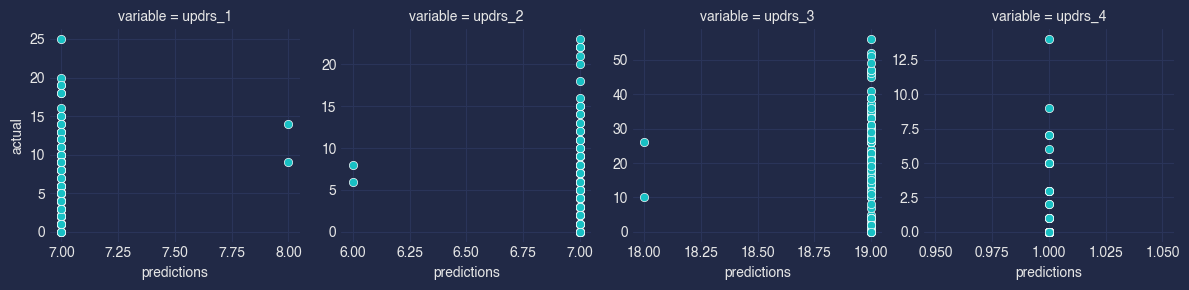

In [375]:
plot_results_0(preds, y_test)
print(smape(y_test[:,0,:], preds))

In [280]:
## A second model


# First model

model1_A = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(1200, activation='tanh'),
        tf.keras.layers.Dropout(0.25),
        layers.Dense(1200, activation='tanh'),
        tf.keras.layers.Dropout(0.25),
        layers.Dense(64, activation='tanh'),
        layers.Dense(n_targets, activation='relu'), # Using a relu layer to ensure that values are > 0.
    ])

model1_A.compile(optimizer='adam', loss='mse')
model1_A.summary()

mod_history = model1_A.fit(X_train_np, y_train[:,0,:],
          validation_split=0.2,
          epochs=20,
)
preds = model1_A.predict(X_test_np)

ValueError: If using all scalar values, you must pass an index